# Library

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device {device}")

Working on device cuda


# Load dataset

In [2]:
# Transform image to 1x784 and normalize colors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
trainset = datasets.MNIST('dataset', download=False, train=True, transform=transform)
valset = datasets.MNIST('dataset', download=False, train=False, transform=transform)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5000, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1000, shuffle=True)

# for idx, (data, target) in enumerate(trainloader):
#     data = data.to(device)
#     target = target.to(device)

# for idx, (data, target) in enumerate(valloader):
#     data = data.to(device)
#     target = target.to(device)    

# Preliminary computation

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])


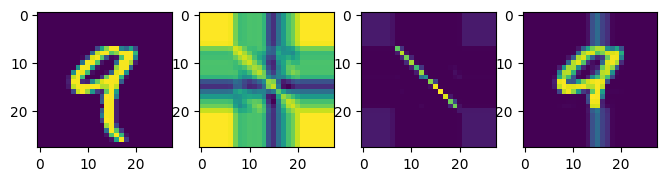

In [30]:
img, label = trainset[4]
input_size = img.shape[1:]

Q = img.clone()
K = img.clone()
V = img.clone()

soft_max = nn.Softmax(dim=2)

QT = torch.transpose(Q, 1, 2)

qTk = torch.bmm(QT, K)
atten_weight = soft_max(qTk)

Att_pool = torch.bmm(atten_weight, V)

fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=4)
plt.subplot(1,4,1)
plt.imshow(Q.squeeze(0))
plt.subplot(1,4,2)
plt.imshow(qTk.squeeze(0))
plt.subplot(1,4,3)
plt.imshow(atten_weight.squeeze(0))

plt.subplot(1,4,4)
plt.imshow(Att_pool.squeeze(0))
Att_pool = Att_pool.squeeze(0)
print(atten_weight.sum(dim=2))

# Model description

$$ \mathrm{Attention}(\mathbf{q},\mathbf{k},\mathbf{v}) = \sum_{i=1}^m{\alpha(\mathbf{q},\mathbf{k}_i) \mathbf{v}_i} $$

where $\mathbf{q}, \mathbf{k}, \mathbf{v} \in \mathbb{R}^d$.

Scaled dot product attention scoring function:

$$ a(\mathbf{q},\mathbf{k}_i) = \mathbf{q}^T \mathbf{k}_i / \sqrt{d} $$

Attention weights

$$ \alpha(\mathbf{q},\mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q},\mathbf{k}_i)) = \frac{\exp(\mathbf{q}^T \mathbf{k}_i / \sqrt{d})}{\sum_{j=1}\exp(\mathbf{q}^T \mathbf{k}_j / \sqrt{d})}$$

In [33]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    # def __init__(self, dropout):
    def __init__(self):
        super().__init__()
        # self.dropout = nn.Dropout(dropout)
        self.soft_max = nn.Softmax(dim=2)
        

    # Shape of queries: (batch_size, img-height, d)
    # Shape of keys: (batch_size, img-height, d)
    # Shape of values: (batch_size, img-height, value dimension)
    def forward(self, queries, keys, values):
        d = queries.shape[2]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(d)
        self.attention_weights = self.soft_max(scores)
        # return torch.bmm(self.dropout(self.attention_weights), values)
        return torch.bmm(self.attention_weights, values)

class sa_NN(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(sa_NN, self).__init__()
        d_model = input_size
        self.W_q = nn.Linear(input_size, d_model, device=device)
        self.W_k = nn.Linear(input_size, d_model, device=device)
        self.W_v = nn.Linear(input_size, d_model, device=device)
        self.W_o = nn.Linear(input_size*input_size, num_classes, device=device)
        
        self.num_classes = num_classes
        
        self.SDPA = DotProductAttention()

        self.log_softmax = nn.LogSoftmax(dim=1)

        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)

    def forward(self, x):
        # Multiply input by weights and add biases
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        out = self.SDPA(Q, K, V)
        out = out.reshape(out.shape[0],-1)
        # out = nn.functional.softmax(self.W_o(out),dim=0)
        out = self.log_softmax(self.W_o(out))
        
        return out
    
    def get_matricies(self, x):
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        y = self.SDPA(Q, K, V)

        return Q,K,V,y,self.SDPA.attention_weights

# Train loop

In [46]:
# Build the Neural Network
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

N_epoch = 1300
model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\sa_NN_epoch_{N_epoch}.pth')) #, map_location=torch.device('cpu')
# model = torch.load('model_backup\sa_NN_epoch_100.pth')
# print(model)
model.to(device)

# criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss which includes softmax
criterion = nn.NLLLoss()  # Use CrossEntropyLoss which includes softmax
# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.96, verbose=False)

# Track loss
loss_list = []

# Training the network
epochs = 100
time0 = time()

for epoch in range(epochs):
    running_loss = 0

    # for images, labels in tqdm(trainloader, leave=False):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.squeeze(1)                 
        
        labels.to(device)

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)               
        
        # This is where the model learns by back propagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
   
    CE_curr = running_loss / len(trainloader)
    loss_list.append(CE_curr)
    # if (epoch%10)==0:
    print(f"Epoch {epoch} - Training loss: {CE_curr:.5f}")
    
    
print(f"\nTraining Time (in minutes) = {(time()-time0)/60:.2f}")

# Convert lists to numpy arrays
loss_array = np.array(loss_list)

# Save arrays to .npy files
np.save('loss_values.npy', loss_array)

# Save the model
torch.save(model.state_dict(), f'model_backup\sa_NN_epoch_{N_epoch+epochs}.pth')


Epoch 0 - Training loss: 0.22400
Epoch 1 - Training loss: 0.22295
Epoch 2 - Training loss: 0.22213
Epoch 3 - Training loss: 0.22170
Epoch 4 - Training loss: 0.22135
Epoch 5 - Training loss: 0.22177
Epoch 6 - Training loss: 0.22170
Epoch 7 - Training loss: 0.22116
Epoch 8 - Training loss: 0.22134
Epoch 9 - Training loss: 0.22164
Epoch 10 - Training loss: 0.22133
Epoch 11 - Training loss: 0.22119
Epoch 12 - Training loss: 0.22133
Epoch 13 - Training loss: 0.22143
Epoch 14 - Training loss: 0.22133
Epoch 15 - Training loss: 0.22103
Epoch 16 - Training loss: 0.22103
Epoch 17 - Training loss: 0.22081
Epoch 18 - Training loss: 0.22092
Epoch 19 - Training loss: 0.22092
Epoch 20 - Training loss: 0.22079
Epoch 21 - Training loss: 0.22078
Epoch 22 - Training loss: 0.22085
Epoch 23 - Training loss: 0.22090
Epoch 24 - Training loss: 0.22089
Epoch 25 - Training loss: 0.22069
Epoch 26 - Training loss: 0.22063
Epoch 27 - Training loss: 0.22059
Epoch 28 - Training loss: 0.22058
Epoch 29 - Training loss

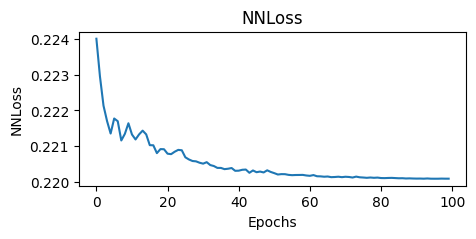

In [47]:
# Plot NLL_loss
plt.figure(figsize=(5, 2))
plt.plot(range(len(loss_array)), loss_array, label='NLLoss')
plt.xlabel('Epochs')
plt.ylabel('NNLoss')
plt.title('NNLoss')
# plt.legend()
plt.show()

# NN test

In [48]:
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load('model_backup\sa_NN_epoch_1400.pth', map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('model_backup\sa_NN_epoch_1000.pth'))
model.to(device)

correct = 0
total = 0

model.eval()
for X, y_true in valloader:
    X = X.squeeze(1) 
    X = X.to(device)
    y_true = y_true.to(device)
    
    outputs = model(X)
    _,y_pred = torch.max(outputs, dim=1)
    total +=y_true.shape[0]
    correct +=int((y_pred==y_true).sum())

print(f"Accuracy = {correct/total: .3f}")

Accuracy =  0.921


# Visualization

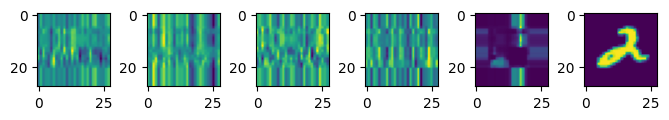

In [58]:
model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load('model_backup\sa_NN_epoch_1400.pth')) # map_location=torch.device('cpu')

img, label = trainset[693]
img = img.to(device)

Q,K,V,Y,att_weights = model.get_matricies(img)

fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=6)
plt.subplot(1,6,1)
plt.imshow(Q.squeeze(0).detach().cpu())
plt.subplot(1,6,2)
plt.imshow(K.squeeze(0).detach().cpu())
plt.subplot(1,6,3)
plt.imshow(V.squeeze(0).detach().cpu())
plt.subplot(1,6,4)
plt.imshow(Y.squeeze(0).detach().cpu())
plt.subplot(1,6,5)
plt.imshow(att_weights.squeeze(0).detach().cpu())
plt.subplot(1,6,6)
plt.imshow(img.squeeze(0).detach().cpu())

plt.subplots_adjust(wspace=0.5)